In [1]:
from scapy.all import rdpcap, IP, TCP, UDP
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from itertools import cycle

In [2]:
PCAP_PATH = "../escenario-prueba/pcaps"
CONTAINER_IP = "10.0.1.5"
SERVER_IP = "10.0.2.5"

In [3]:
def procesar_traza(pcap_path):
    
    try:
        packets = rdpcap(pcap_path)

        start_time = packets[0].time
        label = pcap_path.split("10.0.2.5_")[1].split(".pcap")[0].split("poblation_")[1].split("_")[:3]
        label = "_".join(label)
        
        packet_features = []
        
        total_size = 0
        outgoing = 0
        incoming = 0
        out_size = 0
        in_size = 0
        interarrival_times = []
        last_time = None

        for packet in packets:
            if IP in packet:
                
                if UDP in packet:
                    continue
                
                if not ((packet[IP].dst == SERVER_IP or packet[IP].src == SERVER_IP) and (packet[IP].dst == CONTAINER_IP or packet[IP].src == CONTAINER_IP)):
                    continue
                
                size = len(packet)
                if packet[IP].src == CONTAINER_IP:
                    direction = -1
                    outgoing += 1
                    out_size += size
                else:
                    direction = 1
                    incoming += 1
                    in_size += size
                
                total_size += size
                
                rel_time = float(packet.time - start_time)        
                            
                if last_time is not None:
                    delta = packet.time - last_time
                    interarrival_times.append(float(delta))
                last_time = packet.time

                packet_features.append([
                    direction,
                    size,
                    rel_time,
                ])

        if interarrival_times:
            iat_mean = np.mean(interarrival_times)
            iat_std = np.std(interarrival_times)
            iat_min = np.min(interarrival_times)
            iat_max = np.max(interarrival_times)
            iat_median = np.median(interarrival_times)
        else:
            iat_mean = iat_std = iat_min = iat_max = iat_median = 0

        min_packet_size = np.min([p[1] for p in packet_features]) if packet_features else 0
        max_packet_size = np.max([p[1] for p in packet_features]) if packet_features else 0
        mean_packet_size = np.mean([p[1] for p in packet_features]) if packet_features else 0
        std_packet_size = np.std([p[1] for p in packet_features]) if packet_features else 0

        global_features = {
            "total_packets": incoming + outgoing,
            "incoming_packets": incoming,
            "outgoing_packets": outgoing,
            "incoming_bytes": in_size,
            "outgoing_bytes": out_size,
            "total_size": total_size,
            "incoming_outgoing_ratio": incoming / outgoing if outgoing > 0 else 0,
            "mean_interarrival_time": float(iat_mean),
            "std_interarrival_time": float(iat_std),
            "min_interarrival_time": float(iat_min),
            "max_interarrival_time": float(iat_max),
            "median_interarrival_time": float(iat_median),
            "min_packet_size": int(min_packet_size),
            "max_packet_size": int(max_packet_size),
            "mean_packet_size": float(mean_packet_size),
            "std_packet_size": float(std_packet_size),
        }
                
        return label, global_features, packet_features

    except Exception as e:
        print(f"Error processing {pcap_path}: {e}")
        return None, None, None
    

In [4]:
pcaps = os.listdir(PCAP_PATH)
data = []

for pcap in pcaps[:]:
            
    l, g, p = procesar_traza(pcap_path=os.path.join(PCAP_PATH, pcap))
    if l == None or g == None or p == None:
        print(f"Error processing {pcap}")
        continue
    data.append({"label": l, "packet_features": p, "global_features": g})

    
df = pd.json_normalize(data)
df.describe()

KeyboardInterrupt: 

In [6]:
    
df = pd.json_normalize(data)
df.describe()

,global_features.total_packets,global_features.incoming_packets,global_features.outgoing_packets,global_features.incoming_bytes,global_features.outgoing_bytes,global_features.total_size,global_features.incoming_outgoing_ratio,global_features.mean_interarrival_time,global_features.std_interarrival_time,global_features.min_interarrival_time,global_features.max_interarrival_time,global_features.median_interarrival_time,global_features.min_packet_size,global_features.max_packet_size,global_features.mean_packet_size,global_features.std_packet_size
count,1251.000000,1251.000000,1251.000000,1.251000e+03,1251.000000,1.251000e+03,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.0,1251.000000,1251.000000
mean,3629.819345,2694.537170,935.282174,3.855274e+06,101129.336531,3.956403e+06,2.737735,0.000503,0.017671,-0.000001,0.945421,0.000003,57.011990,1514.0,1059.548484,641.165199
std,2636.530041,1995.811019,659.916788,2.907650e+06,45048.450658,2.951098e+06,0.554894,0.000682,0.020766,0.000001,0.990254,0.000001,5.205137,0.0,63.921488,22.106023
min,592.000000,405.000000,179.000000,5.509000e+05,29976.000000,5.812090e+05,1.632959,0.000027,0.000361,-0.000026,0.011827,0.000002,54.000000,1514.0,879.511628,557.014089
25%,959.000000,657.000000,307.000000,8.702095e+05,69572.500000,9.408965e+05,2.300920,0.000087,0.000875,-0.000001,0.027554,0.000002,54.000000,1514.0,1007.423179,627.026578
50%,3603.000000,2716.000000,809.000000,3.934862e+06,94648.000000,4.029767e+06,2.679397,0.000276,0.001841,-0.000001,0.040491,0.000002,54.000000,1514.0,1073.243631,644.864160
75%,4033.500000,3010.500000,1133.000000,4.281950e+06,112822.500000,4.388778e+06,3.096459,0.000595,0.032379,-0.000001,2.011696,0.000003,66.000000,1514.0,1105.677812,657.614011
max,9604.000000,6823.000000,2985.000000,9.812224e+06,245050.000000,1.002991e+07,5.137670,0.003627,0.082708,0.000001,2.063408,0.000009,66.000000,1514.0,1216.626695,689.726521


In [7]:
gf_cols = [col for col in df.columns if col.startswith("global_features")]
mapping = { col: col.replace("global_features.", "") for col in gf_cols }
new_names = list(mapping.values())
print("Columnas renombradas:")
for old, new in mapping.items():
    print(f"  {old} → {new}")
df = df.rename(columns=mapping)
df.describe()

Columnas renombradas:
  global_features.total_packets → total_packets
  global_features.incoming_packets → incoming_packets
  global_features.outgoing_packets → outgoing_packets
  global_features.incoming_bytes → incoming_bytes
  global_features.outgoing_bytes → outgoing_bytes
  global_features.total_size → total_size
  global_features.incoming_outgoing_ratio → incoming_outgoing_ratio
  global_features.mean_interarrival_time → mean_interarrival_time
  global_features.std_interarrival_time → std_interarrival_time
  global_features.min_interarrival_time → min_interarrival_time
  global_features.max_interarrival_time → max_interarrival_time
  global_features.median_interarrival_time → median_interarrival_time
  global_features.min_packet_size → min_packet_size
  global_features.max_packet_size → max_packet_size
  global_features.mean_packet_size → mean_packet_size
  global_features.std_packet_size → std_packet_size


,total_packets,incoming_packets,outgoing_packets,incoming_bytes,outgoing_bytes,total_size,incoming_outgoing_ratio,mean_interarrival_time,std_interarrival_time,min_interarrival_time,max_interarrival_time,median_interarrival_time,min_packet_size,max_packet_size,mean_packet_size,std_packet_size
count,1251.000000,1251.000000,1251.000000,1.251000e+03,1251.000000,1.251000e+03,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.000000,1251.0,1251.000000,1251.000000
mean,3629.819345,2694.537170,935.282174,3.855274e+06,101129.336531,3.956403e+06,2.737735,0.000503,0.017671,-0.000001,0.945421,0.000003,57.011990,1514.0,1059.548484,641.165199
std,2636.530041,1995.811019,659.916788,2.907650e+06,45048.450658,2.951098e+06,0.554894,0.000682,0.020766,0.000001,0.990254,0.000001,5.205137,0.0,63.921488,22.106023
min,592.000000,405.000000,179.000000,5.509000e+05,29976.000000,5.812090e+05,1.632959,0.000027,0.000361,-0.000026,0.011827,0.000002,54.000000,1514.0,879.511628,557.014089
25%,959.000000,657.000000,307.000000,8.702095e+05,69572.500000,9.408965e+05,2.300920,0.000087,0.000875,-0.000001,0.027554,0.000002,54.000000,1514.0,1007.423179,627.026578
50%,3603.000000,2716.000000,809.000000,3.934862e+06,94648.000000,4.029767e+06,2.679397,0.000276,0.001841,-0.000001,0.040491,0.000002,54.000000,1514.0,1073.243631,644.864160
75%,4033.500000,3010.500000,1133.000000,4.281950e+06,112822.500000,4.388778e+06,3.096459,0.000595,0.032379,-0.000001,2.011696,0.000003,66.000000,1514.0,1105.677812,657.614011
max,9604.000000,6823.000000,2985.000000,9.812224e+06,245050.000000,1.002991e+07,5.137670,0.003627,0.082708,0.000001,2.063408,0.000009,66.000000,1514.0,1216.626695,689.726521


In [8]:
df["label_size"] = df["label"].str.split("_").str[0].astype(int)
df["label_imgs"] = df["label"].str.split("_").str[1].astype(int)
combined_counts = df.groupby(['label_size', 'label_imgs']).size().reset_index(name='Count')
display(combined_counts)

,label_size,label_imgs,Count
0,511828,5,4
1,511828,7,2
2,511828,9,1
3,511828,11,4
4,511828,13,4
...,...,...,...
295,9239647,55,5
296,9239647,57,4
297,9239647,59,5
298,9239647,61,5


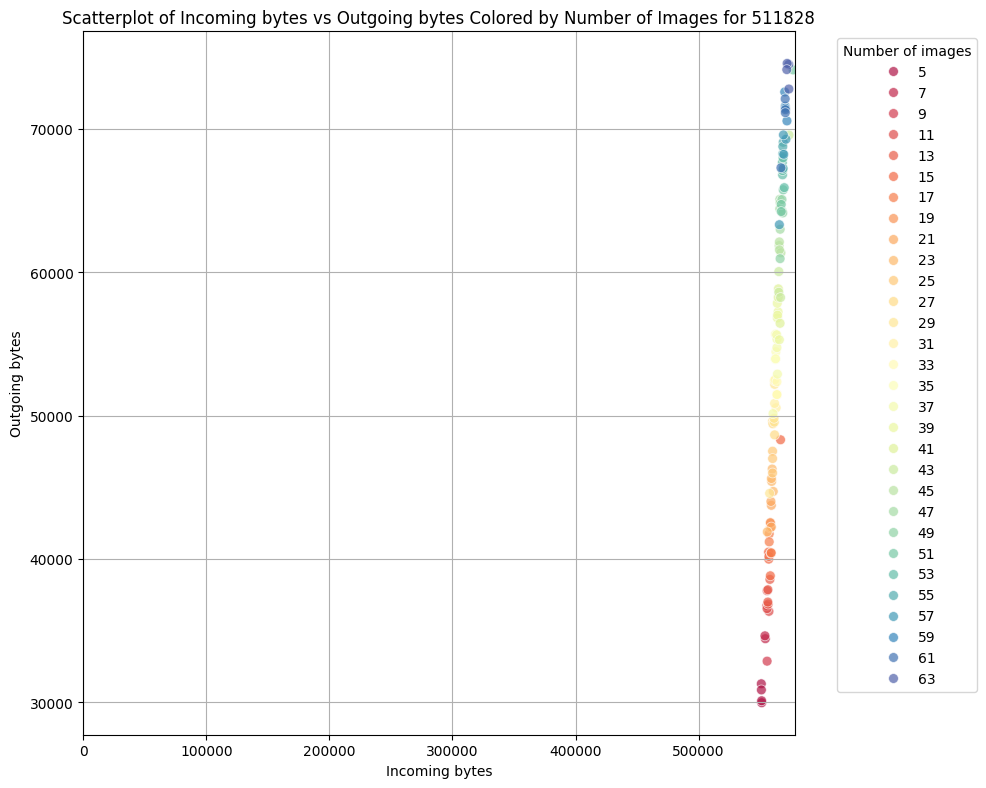

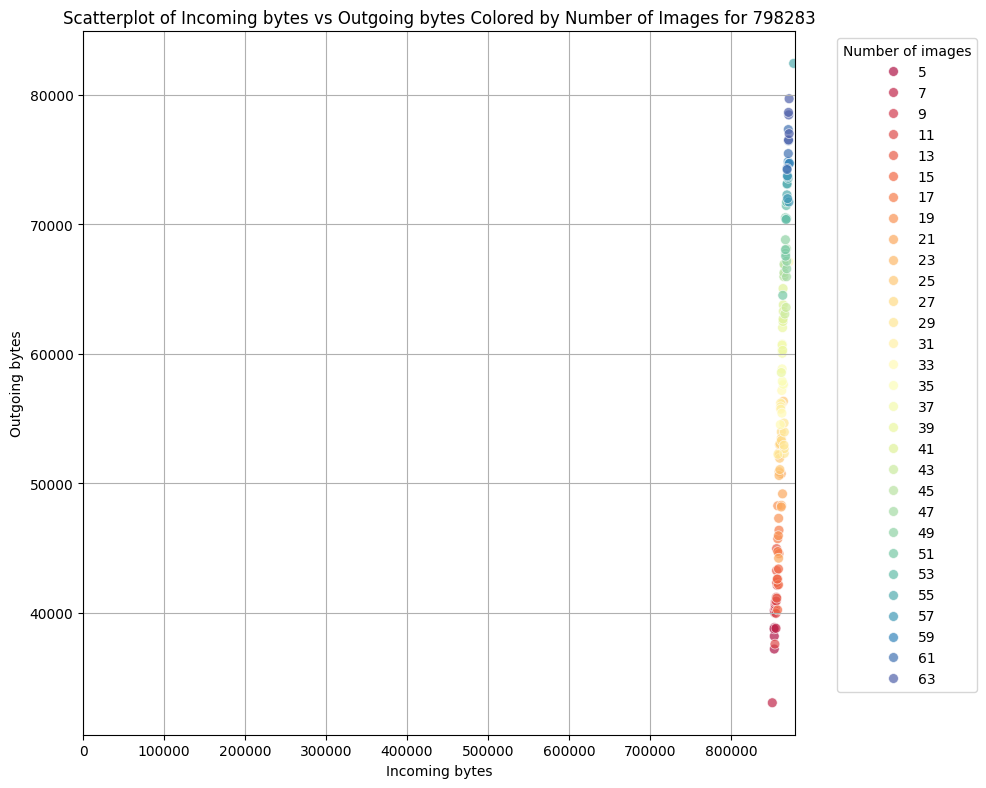

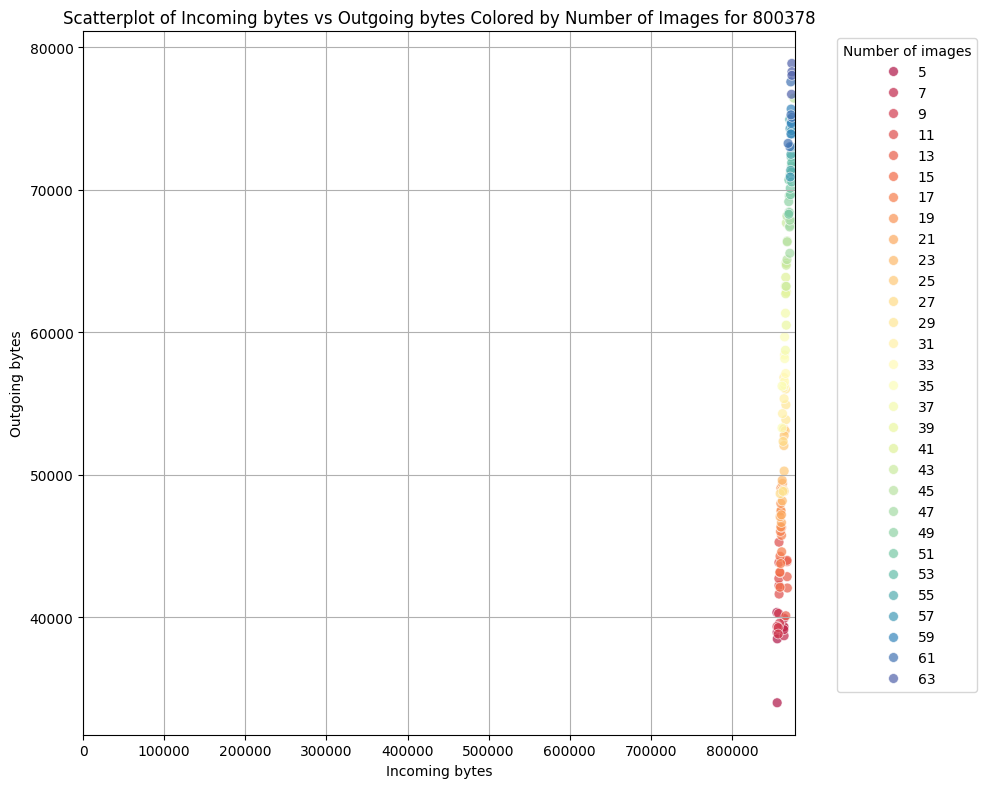

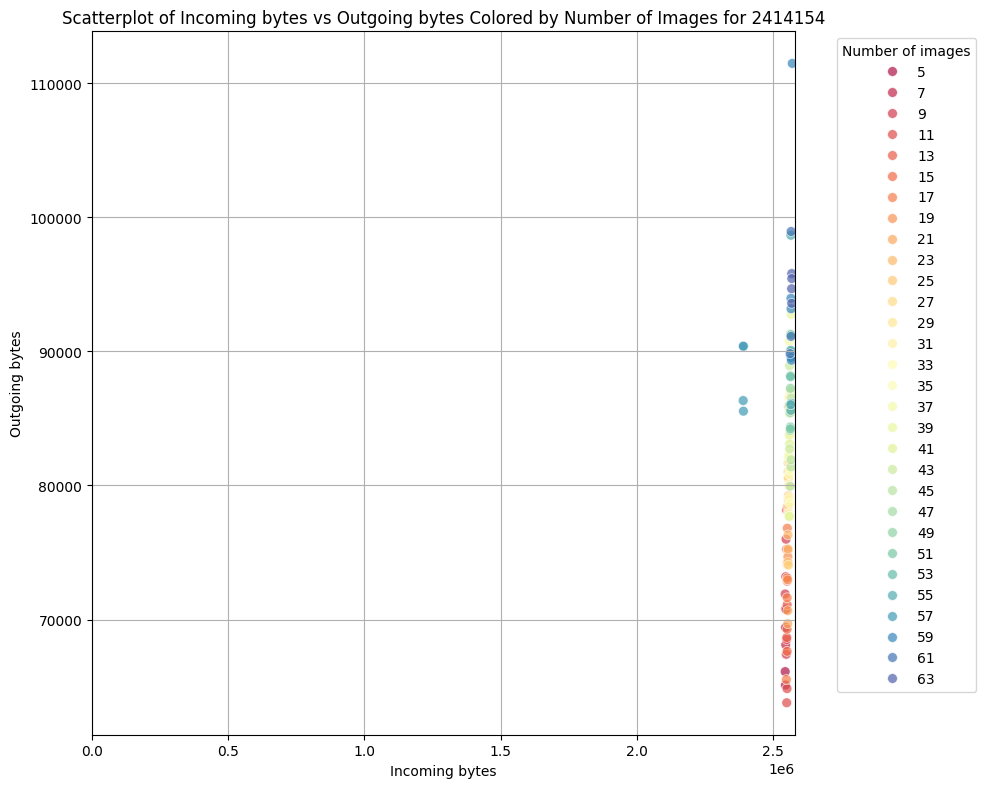

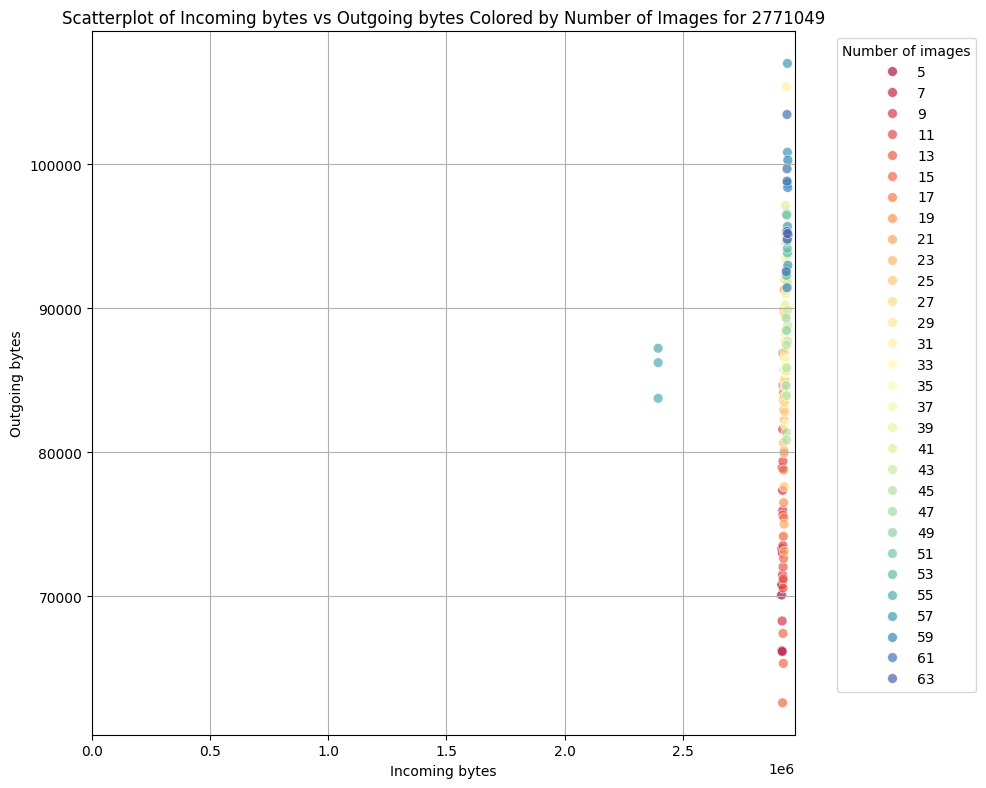

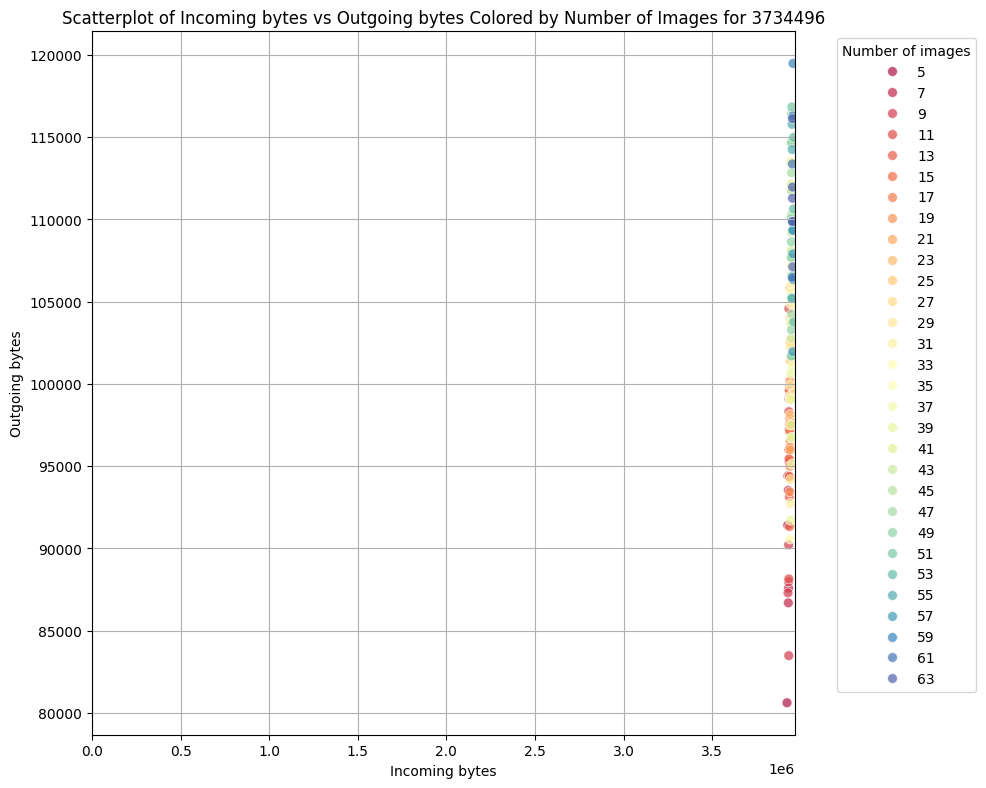

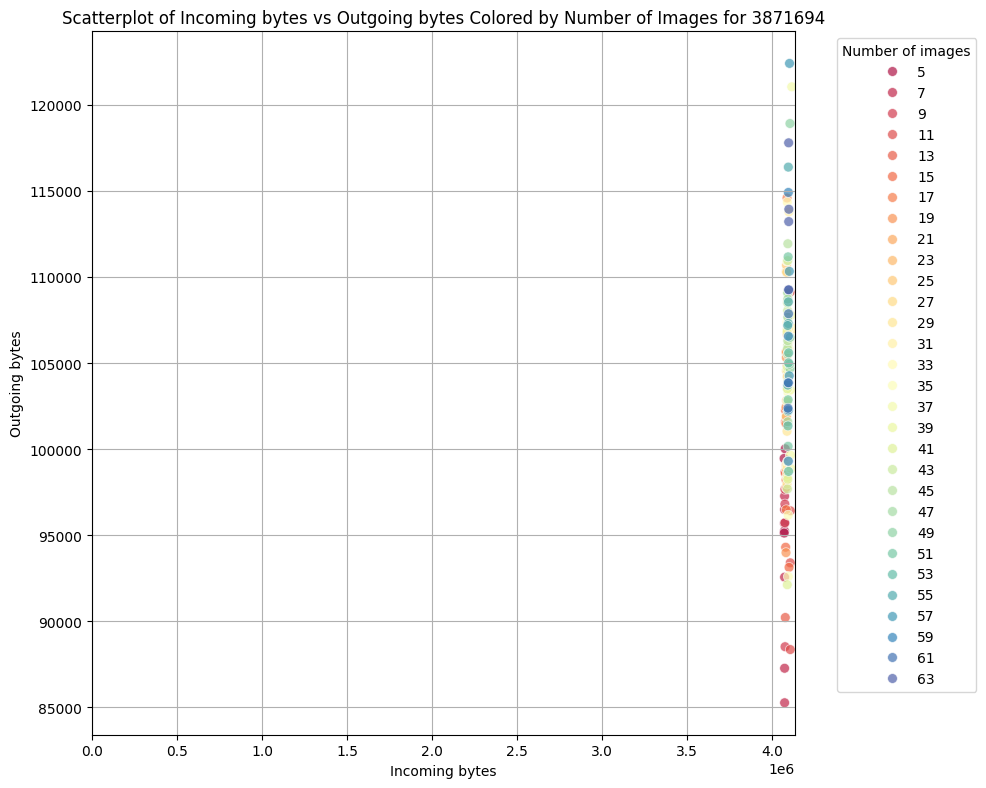

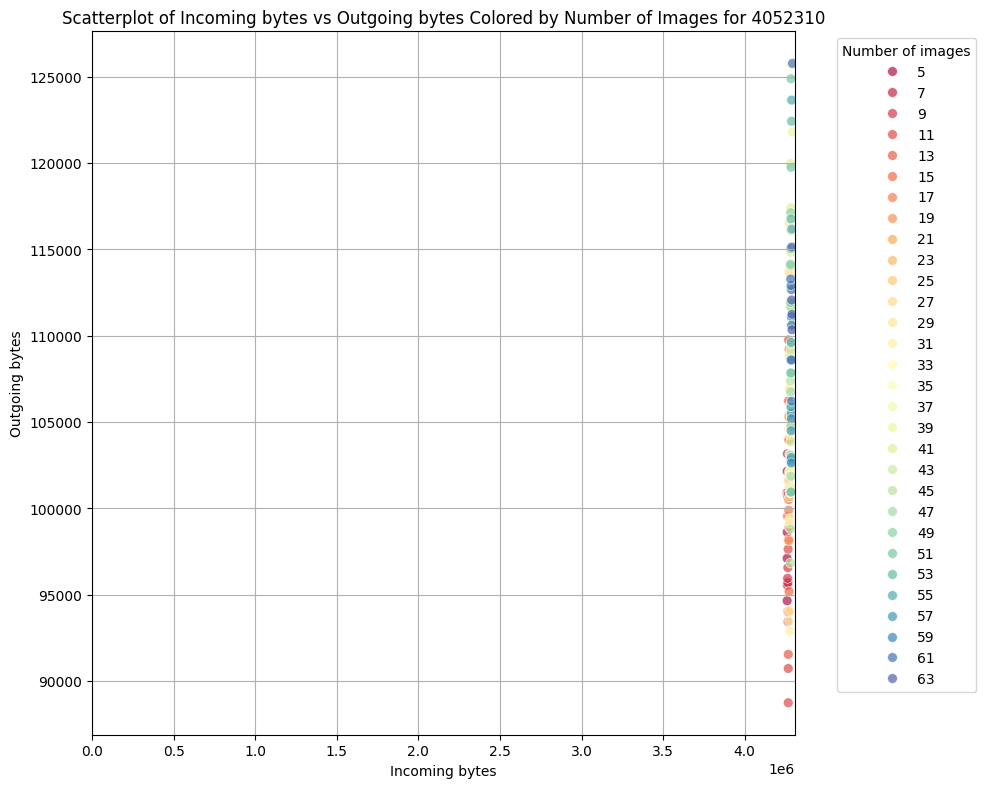

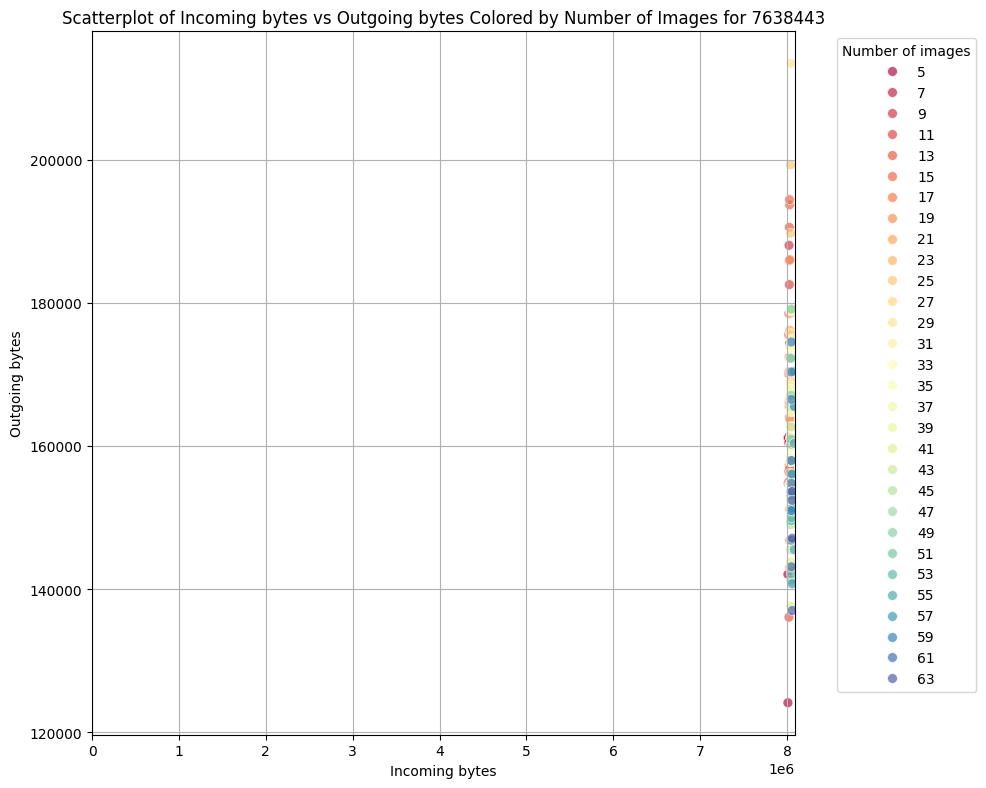

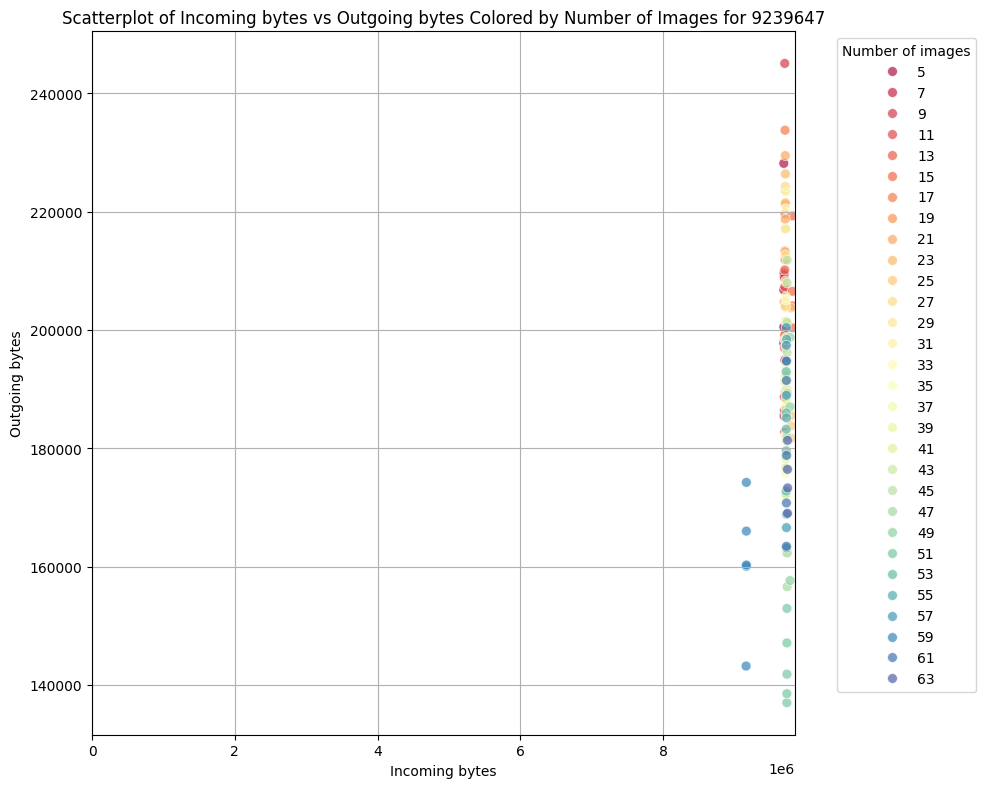

In [11]:
import seaborn as sns
label_sizes = sorted(df['label_size'].unique())
for label_size in label_sizes:
    subset = df[df['label_size'] == label_size]
    X = subset[["incoming_bytes", "outgoing_bytes"]]
    y = subset["label_imgs"]
        
    df_plot = X.copy()
    df_plot['label_imgs'] = y
    df_plot.sort_values(by='label_imgs', inplace=True)
    df_plot['label_imgs'] = df_plot['label_imgs'].astype(str)    
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_plot, x='incoming_bytes', y='outgoing_bytes', hue='label_imgs', palette='Spectral', s=50, alpha=0.7)
    plt.title(f'Scatterplot of Incoming bytes vs Outgoing bytes Colored by Number of Images for {label_size}')
    plt.xlabel('Incoming bytes')
    plt.ylabel('Outgoing bytes')
    plt.legend(title='Number of images', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xlim(0)
    plt.tight_layout()
    plt.show()    
